In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


# 

In [23]:
df = pd.read_csv('Project_Data.csv')
df.head()
df.shape

(7043, 31)

In [24]:
df.isna().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Reason         5174
dtype: int64

In [25]:
# this shows that the only null values are for reason when churn value is 0 which is wholly logical.
nullReason = df[df['Churn Reason'].isna()]
nullReason['Churn Value'].value_counts()

Churn Value
0    5174
Name: count, dtype: int64

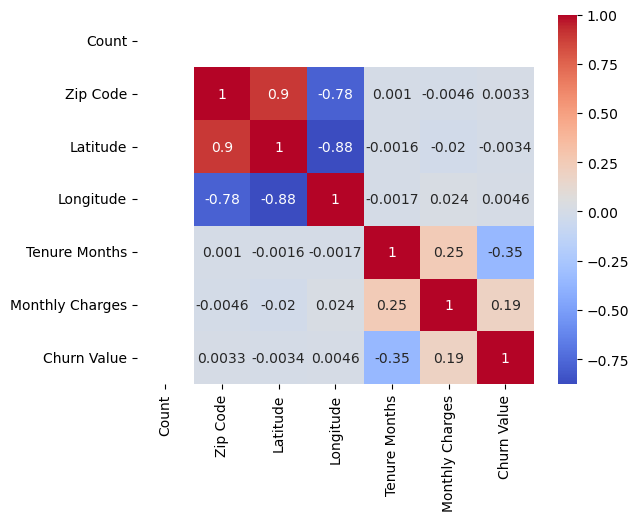

In [26]:
# Creating correlation to see what factors have a negative correlation with churn value.
sns.heatmap(data = df.corr(numeric_only = True),
            cmap = 'coolwarm', 
            annot=True)
plt.show()

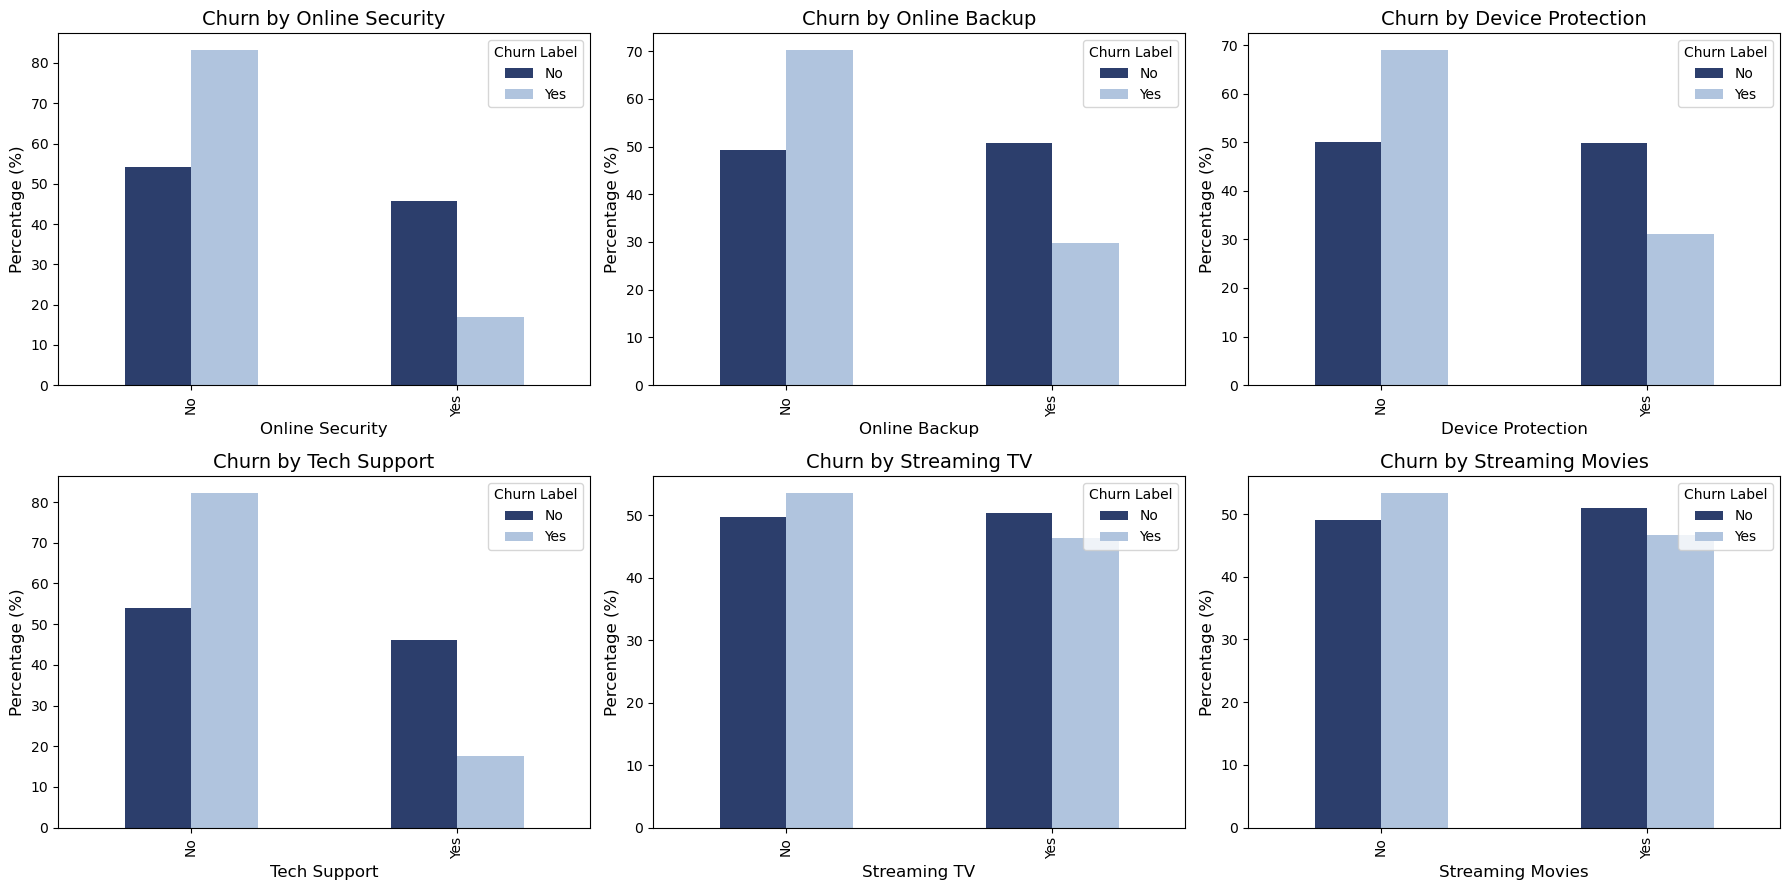

In [27]:
# Columns to analyze
columns = ['Online Security', 'Online Backup', 'Device Protection', 'Tech Support','Streaming TV', 'Streaming Movies']

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 9))
axes = axes.flatten()

# Remove rows where InternetService is 'No'
df_internet = df[df['Internet Service'] != 'No']

# Loop through columns
for idx, (col) in enumerate(columns):
    # Calculate crosstab with percentages
    crosstab = pd.crosstab(df_internet[col], df_internet['Churn Label'], normalize='columns') * 100
    
    # Create bar plot
    crosstab.plot(kind='bar', ax=axes[idx], color=['#2c3e6c', '#b0c4de'][:len(crosstab.columns)])
    
    # Set titles and labels
    axes[idx].set_title('Churn by ' + col, fontsize=14)
    axes[idx].set_xlabel(col, fontsize=12)
    axes[idx].set_ylabel('Percentage (%)', fontsize=12)
    axes[idx].legend(title='Churn Label', loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

In [28]:
# Feature engineering function, maps binary columns to integers (0 and 1)
def feature_engineering(df):
    df_local = df.copy()

    # Convert gender to numeric
    df_local['Gender'] = df_local['Gender'].map({'Male': 0, 'Female': 1})

    # Binary yes/no features
    fe_list = ['Senior Citizen', 'Partner', 'Dependents',
               'Phone Service', 'Paperless Billing']
    for feature in fe_list:
        if feature in df_local.columns:
            df_local[feature] = df_local[feature].map({'No': 0, 'Yes': 1})

    # Internet-related categorical features (one-hot encode)
    internet_list = [
        'Online Security', 'Online Backup', 'Device Protection',
        'Tech Support', 'Streaming TV', 'Streaming Movies'
    ]
    df_local = pd.get_dummies(
        data=df_local,
        columns=internet_list,
        drop_first=True,
        dtype='int'
    )

    # Multiple Lines mapping
    if 'Multiple Lines' in df_local.columns:
        df_local['Multiple Lines'] = df_local['Multiple Lines'].map({
            'No': 0,
            'Yes': 1,
            'No phone service': 0
        })

    return df_local

# Rename columns for consistency
df = df.rename(columns={
    'CustomerID': 'customer_id',
    'Churn Label': 'churn_flag',
    'Churn Value': 'churn_value',
    'Churn Reason': 'churn_reason',
    'Tenure Months': 'tenure_months',
    'Monthly Charges': 'monthly_charges',
    'Total Charges': 'total_charges'
})

# Apply feature engineering
df_eng = feature_engineering(df)

print("Feature engineering applied.")
display(df.head())

Feature engineering applied.


,customer_id,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,monthly_charges,total_charges,churn_flag,churn_value,churn_reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,Competitor had better devices


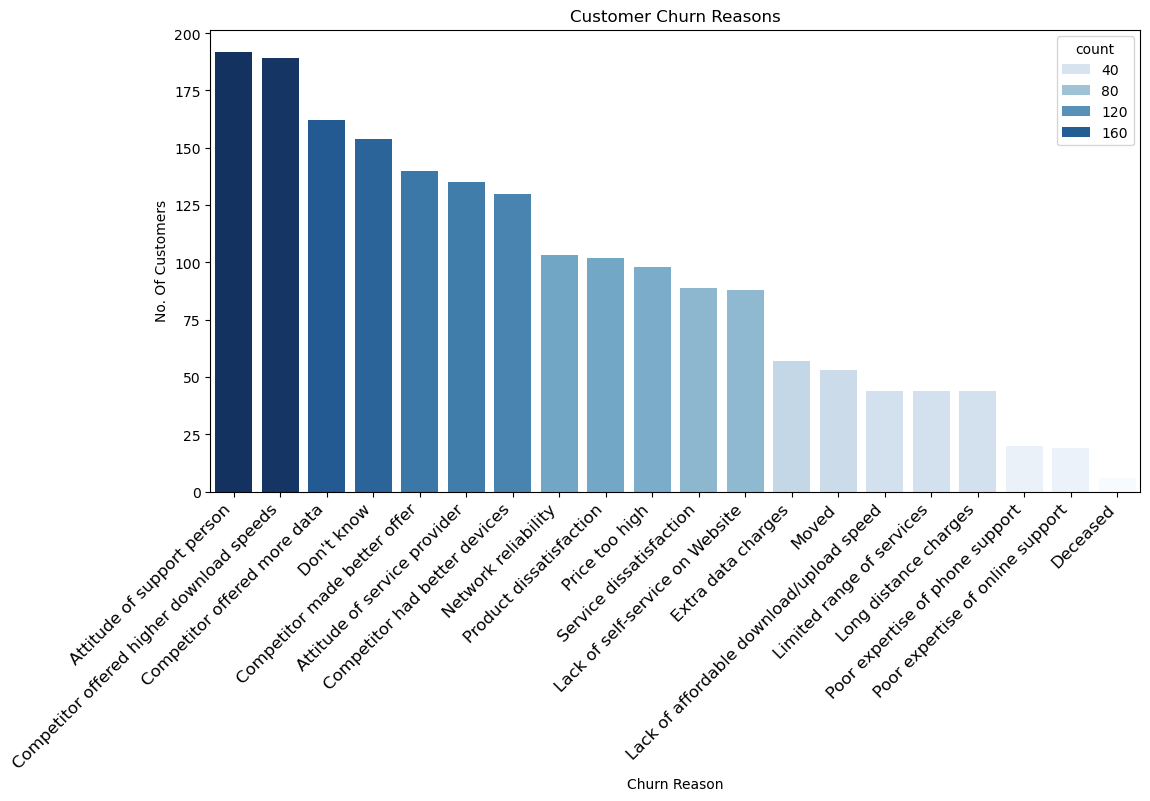

In [29]:
# Graphing the top reasons customers gave for churning
churnValue_Reason = df[['churn_value', 'churn_reason']]
churnValue_Reason
churned = churnValue_Reason[churnValue_Reason['churn_value'] == 1]
reasonCounts = churned.value_counts()
reasonCounts = pd.DataFrame(reasonCounts).reset_index().rename(columns={'index': 'churn_reason', 0: 'Count'})
reasonCounts
plt.figure(figsize=(12,6))
sns.barplot(x=reasonCounts['churn_reason'], y=reasonCounts['count'], palette='Blues', hue = reasonCounts['count'])
plt.xlabel('Churn Reason')
plt.xticks(rotation= 45, # rotating labels
           horizontalalignment = 'right', # aligning them with the bars
           fontweight = 'light',
           fontsize = 'large' # setting the fonts
          )
plt.ylabel('No. Of Customers')
plt.title('Customer Churn Reasons')
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86      1009
           1       0.68      0.48      0.57       400

    accuracy                           0.79      1409
   macro avg       0.75      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

ROC AUC: 0.8322732903865213


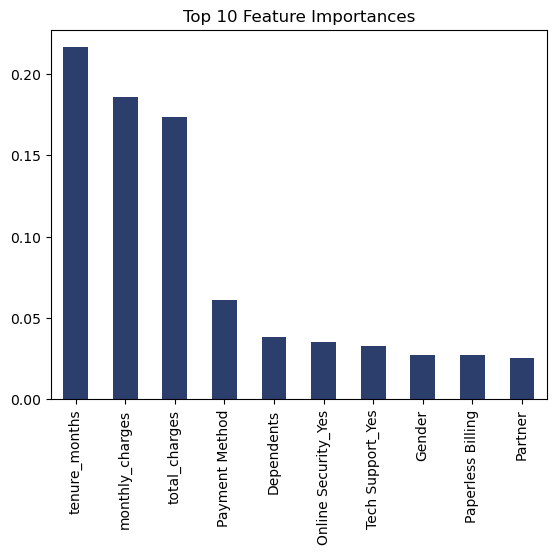

In [ ]:
# Features and target
drop_cols = [
    'Country',
    'State',
    'City',
    'Zip Code',
    'Lat Long',
    'Latitude',
    'Longitude',
    'customer_id',
    'churn_flag',
    'churn_value',
    'churn_reason',
    'Internet Service',
    'Contract',
    'Tenure Group'
    ]
cat_cols = df_eng.select_dtypes(include=['object']).columns
for col in cat_cols:
    df_eng[col] = LabelEncoder().fit_transform(df_eng[col].astype(str))

X = df_eng.drop(columns=drop_cols, errors='ignore')

y = df_eng['churn_flag']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

# Evaluation
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

# Feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances[:10].plot(kind='bar', color='#2c3e6c')
plt.title("Top 10 Feature Importances")
plt.show()

In [33]:
# Feature engineering function, maps binary columns to integers (0 and 1)
def feature_engineering(df):
    df_local = df.copy()

    # Convert gender to numeric
    df_local['Gender'] = df_local['Gender'].map({'Male': 0, 'Female': 1})

    # Binary yes/no features
    fe_list = ['Senior Citizen', 'Partner', 'Dependents',
               'Phone Service', 'Paperless Billing']
    for feature in fe_list:
        if feature in df_local.columns:
            df_local[feature] = df_local[feature].map({'No': 0, 'Yes': 1})

    # Internet-related categorical features (one-hot encode)
    internet_list = [
        'Online Security', 'Online Backup', 'Device Protection',
        'Tech Support', 'Streaming TV', 'Streaming Movies', 'Internet Service',
        'Contract', 'Payment Method'
    ]
    df_local = pd.get_dummies(
        data=df_local,
        columns=internet_list,
        drop_first=True,
        dtype='int'
    )

    # Multiple Lines mapping
    if 'Multiple Lines' in df_local.columns:
        df_local['Multiple Lines'] = df_local['Multiple Lines'].map({
            'No': 0,
            'Yes': 1,
            'No phone service': 0
        })

    return df_local


In [34]:

# Select features for modeling
features = [
    'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'tenure_months',
    'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security',
    'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
    'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
    'monthly_charges', 'total_charges'
]
X = df[features].copy()
y = df['churn_value']

# Train Test Split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
X_train_fe = feature_engineering(X_train)
X_test_fe = feature_engineering(X_test)
### Fill missing values
median = X_train_fe.loc[~(X_train_fe['total_charges'] == ' ')]['total_charges'].astype('float').median()
print(f'The median value of total charges is {median}')
X_train_fe['total_charges'] = X_train_fe['total_charges'].replace({' ': median})
X_test_fe['total_charges'] = X_test_fe['total_charges'].replace({' ': median})

The median value of total charges is 1388.0


In [40]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_fe)
X_test_scaled = scaler.transform(X_test_fe)

In [44]:
log_reg = LogisticRegression(
    random_state=42,
    class_weight= 'balanced',
    max_iter = 1000,
    C=1.0
)

log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

In [48]:
## There are 4 main metrics we're interested in at this stage: 
#accuracy, precision, recall and F1.
## The 'metrics' module from sklearn covers all of them (and more!) 
#So we can use a function like the one below

def get_results(actual, predicted):
    print("The confusion matrix for your predictions is:")
    print(confusion_matrix(actual, predicted), "\n")
    print(f'The accuracy of your model is: {accuracy_score(actual, predicted)}')
    print(f'The recall of your model is: {recall_score(actual, predicted)}')
    print(f'The precision of your model is: {precision_score(actual, predicted)}')
    print(f'The F1-score of your model is: {f1_score(actual, predicted)}')

get_results(y_test, y_pred)

The confusion matrix for your predictions is:
[[728 281]
 [ 75 325]] 

The accuracy of your model is: 0.7473385379701917
The recall of your model is: 0.8125
The precision of your model is: 0.5363036303630363
The F1-score of your model is: 0.6461232604373758


In [53]:
X = df[features].copy()
y = df['churn_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_fe = feature_engineering(X_train)
X_test_fe = feature_engineering(X_test)
### Fill missing values
median = X_train_fe.loc[~(X_train_fe['total_charges'] == ' ')]['total_charges'].astype('float').median()
print(f'The median value of total charges is {median}')
X_train_fe['total_charges'] = X_train_fe['total_charges'].replace({' ': median})
X_test_fe['total_charges'] = X_test_fe['total_charges'].replace({' ': median})

The median value of total charges is 1388.0


In [58]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=124)

scores = cross_val_score(tree, X_train_fe, y_train, cv = 5)
print(scores)

[0.74534161 0.71960958 0.73025732 0.72404614 0.73889876]


In [71]:
rf = RandomForestClassifier(n_estimators=50)
rf_score = cross_val_score(rf, X_train_fe, y_train, cv=5)
print(rf_score)

[0.78527063 0.80035492 0.78438332 0.77373558 0.80195382]


In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', None]
}
gs = GridSearchCV(rf, param_grid, cv=5)

gs.fit(X_train_fe, y_train)

print(gs.best_score_)

gs.best_params_
# {'class_weight': None, 'max_depth': 10, 'max_features': 'sqrt','min_samples_split': 5,'n_estimators': 200}

0.8067104701174623


{'class_weight': None,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_split': 5,
 'n_estimators': 200}

In [78]:
bestTree = RandomForestClassifier(gs.best_params_)
rf_score = cross_val_score(rf, X_train_fe, y_train, cv=5)
print(rf_score)
rf.fit(X_train_fe, y_train)
# Predictions
y_pred = rf.predict(X_test_fe)
y_prob = rf.predict_proba(X_test_fe)[:, 1]

# Evaluation
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


[0.7905945  0.80301686 0.78970719 0.78527063 0.80017762]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1009
           1       0.68      0.52      0.59       400

    accuracy                           0.79      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.78      0.79      0.79      1409

ROC AUC: 0.8369425173439048
